# Notebook for LSTM - Model Testing

see "RNN all data" notebook

contains similar test, only with the "vector_remove_party_300d-3-5.tsv"-matrix


In [1]:
# imports
import csv
import numpy as np
import pandas as pd
import import_ipynb
import spacy
from sklearn.model_selection import train_test_split
from tqdm import tqdm

nlp = spacy.load(
    "de_core_news_lg", exclude=["tok2vec", "ner", "parser", "attribute_ruler"]
)
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import make_sampling_table, pad_sequences
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import (
    Dot,
    Embedding,
    Flatten,
    Dense,
    GlobalAveragePooling1D,
    LSTM,
    concatenate,
    Dropout,
    Bidirectional,
)
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
#data
data = pd.DataFrame(columns=['tweet', 'party'])

afd = pd.read_csv('../cleaned-data/AfD.csv', quoting=csv.QUOTE_NONE)['text']
afd = pd.DataFrame([[i, 0] for i in afd], columns=['tweet', 'party'])

data = data.append(afd, ignore_index=True)

cdu = pd.read_csv('../cleaned-data/CDU.csv',quoting=csv.QUOTE_NONE)['text']
csu = pd.read_csv('../cleaned-data/CSU.csv',quoting=csv.QUOTE_NONE)['text']

cdu = pd.DataFrame([[i, 1] for i in cdu], columns=['tweet', 'party'])
csu = pd.DataFrame([[i, 1] for i in csu], columns=['tweet', 'party'])

data = data.append(cdu, ignore_index=True)
data = data.append(csu, ignore_index=True)

fdp = pd.read_csv('../cleaned-data/FDP.csv',quoting=csv.QUOTE_NONE)['text']
fdp = pd.DataFrame([[i, 2] for i in fdp], columns=['tweet', 'party'])

data = data.append(fdp, ignore_index=True)

gru = pd.read_csv('../cleaned-data/GRÜNE.csv',quoting=csv.QUOTE_NONE)['text']
gru = pd.DataFrame([[i, 3] for i in gru], columns=['tweet', 'party'])

data = data.append(gru, ignore_index=True)

lin = pd.read_csv('../cleaned-data/LINKE.csv',quoting=csv.QUOTE_NONE)['text']
lin = pd.DataFrame([[i, 4] for i in lin], columns=['tweet', 'party'])

data = data.append(lin, ignore_index=True)

spd = pd.read_csv('../cleaned-data/SPD.csv',quoting=csv.QUOTE_NONE)['text']
spd = pd.DataFrame([[i, 5] for i in spd], columns=['tweet', 'party'])

data = data.append(spd, ignore_index=True)
data = data.dropna()

In [3]:
# loading vocab and embedding matrix
words = []
em_matrix = np.genfromtxt(fname = "../word_embedding/embeddings/vector_remove_party_300d-3-5.tsv", delimiter = "\t" )       
with open("../vocab/remove_party_vocab_token.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader) #skip header
    vocab = {rows[0]:int(rows[2]) for rows in reader}
# adding unknown token for new words
vocab['UNK'] = len(vocab)

In [5]:
# transforming data
# 1.) tokenizing
# 1a.) removing party tokens
# 2.) padding to length 50
parties = ["afd","cdu","csu","linke","fdp","gruene", "spd", "union"]
data['vectors'] = data['tweet'].apply([lambda x: [vocab[y.text] if y.text in vocab and y.text.lower() not in parties else vocab['UNK'] for y in nlp(str(x))]])
data['vectors'] = data['vectors'].apply(lambda x: pad_sequences([x], maxlen=50, dtype=int, padding='post',value=0)[-1])
data['len'] = data['vectors'].apply(lambda x: len(x))
data_len = data['len'].max()
data

,tweet,party,vectors,len
0,Teenie auf dem Weg nach Malle Nein Aussenminis...,0,"[36516, 16, 35, 293, 60, 44990, 201, 1506, 16,...",50
1,Heute Abend bin ich gemeinsam mit user zu Gast...,0,"[130, 399, 143, 21, 376, 13, 1, 9, 1243, 121, ...",50
2,Berlin 17 Grad Die Frisur passt Unsere Motivat...,0,"[102, 1005, 2690, 18, 11972, 858, 517, 5791, 1...",50
3,Lieber user lieber user ich gratuliere Ihnen h...,0,"[648, 1, 317, 1, 21, 4051, 224, 2076, 55, 1765...",50
4,Seit gestern koennen die Mitglieder unserer Af...,0,"[574, 438, 99, 2, 915, 232, 75059, 458, 3921, ...",50
...,...,...,...,...
306944,user Danke,5,"[1, 87, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",50
306945,Herzlich Willkommen in der SPD Seit gestern Ab...,5,"[3502, 2393, 5, 3, 93, 574, 438, 399, 30, 1280...",50
306946,Hatte 4 gute Jahre als Vors SPD BTF Freue mich...,5,"[2345, 260, 207, 205, 33, 20002, 93, 75059, 69...",50
306947,Glueckwunsch an Nils Annen,5,"[178, 27, 18454, 45880, 0, 0, 0, 0, 0, 0, 0, 0...",50


In [6]:
# preparing label: transforming integer to vector
y = tf.keras.utils.to_categorical(data['party'].to_numpy())
y
# preparing data (dataframe to np.array) 
X = np.array([np.array(x) for x in data['vectors']])
X

array([[36516,    16,    35, ...,     0,     0,     0],
       [  130,   399,   143, ...,     0,     0,     0],
       [  102,  1005,  2690, ...,     0,     0,     0],
       ...,
       [ 2345,   260,   207, ...,     0,     0,     0],
       [  178,    27, 18454, ...,     0,     0,     0],
       [   36,    98,   652, ...,     0,     0,     0]])

In [7]:
# splitting into train/test/validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4)

In [8]:
# Deep learning Model 1 (see RNN_all_data notebook)
class RnnModel():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64))(x)
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(64, activation="relu")(x)
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model


In [9]:
# Deep learning Model 2 (see RNN_all_data notebook)
class RnnModel2():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        x = Bidirectional(LSTM(256, return_sequences=True))(x)
        x = Bidirectional(LSTM(128))(x)
        x = Dense(256, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(64, activation="relu")(x)
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model

In [10]:
# test 1 with no party matrix
m2 = RnnModel2(em_matrix, 300, 50)
h2 = m2.model.fit(X_train, y_train, epochs = 5, batch_size = 512, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/5
476/476 [==============================] - 988s 2s/step - loss: 0.3914 - accuracy: 0.3737 - val_loss: 0.3410 - val_accuracy: 0.4851
Epoch 2/5
476/476 [==============================] - 890s 2s/step - loss: 0.3064 - accuracy: 0.5535 - val_loss: 0.3102 - val_accuracy: 0.5467
Epoch 3/5
476/476 [==============================] - 892s 2s/step - loss: 0.2547 - accuracy: 0.6417 - val_loss: 0.3114 - val_accuracy: 0.5579
Epoch 4/5
476/476 [==============================] - 873s 2s/step - loss: 0.2161 - accuracy: 0.7005 - val_loss: 0.3206 - val_accuracy: 0.5583
Epoch 5/5
476/476 [==============================] - 850s 2s/step - loss: 0.1840 - accuracy: 0.7471 - val_loss: 0.3647 - val_accuracy: 0.5567


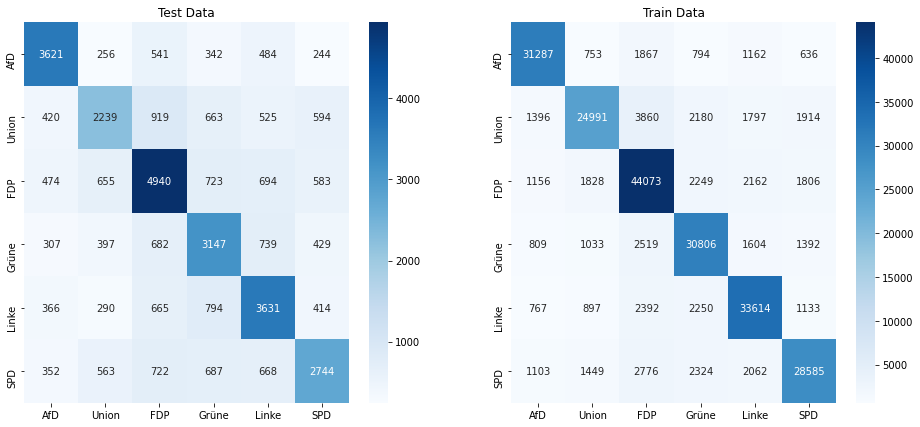

Party: 	 Test 	 Train
Afd:	 5488 	 36499
Union:	 5360 	 36138
FDP:	 8069 	 53274
Grüne:	 5701 	 38163
Linke:	 6160 	 41053
SPD:	 5736 	 38299

Acc:	 55.66% 79.43%


In [11]:
#visualizing test 1
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = m2.model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');


# Block to evaluate test data
yhat_train = m2.model.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

In [12]:
# Deep learning Model 4 (see RNN_all_data notebook)
class RnnModel4():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64))(x)
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(128, activation="relu")(x)
        x = Dense(64, activation="relu")(x)
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model

In [13]:
# test 2 with no party matrix
m5 = RnnModel4(em_matrix, 300, 50)
h5 = m5.model.fit(X_train, y_train, epochs = 5, batch_size = 512, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/5
476/476 [==============================] - 436s 905ms/step - loss: 0.4066 - accuracy: 0.3382 - val_loss: 0.3563 - val_accuracy: 0.4455
Epoch 2/5
476/476 [==============================] - 431s 906ms/step - loss: 0.3240 - accuracy: 0.5158 - val_loss: 0.3210 - val_accuracy: 0.5186
Epoch 3/5
476/476 [==============================] - 431s 905ms/step - loss: 0.2687 - accuracy: 0.6177 - val_loss: 0.3101 - val_accuracy: 0.5461
Epoch 4/5
476/476 [==============================] - 430s 904ms/step - loss: 0.2275 - accuracy: 0.6841 - val_loss: 0.3253 - val_accuracy: 0.5509
Epoch 5/5
476/476 [==============================] - 431s 906ms/step - loss: 0.1946 - accuracy: 0.7310 - val_loss: 0.3628 - val_accuracy: 0.5539


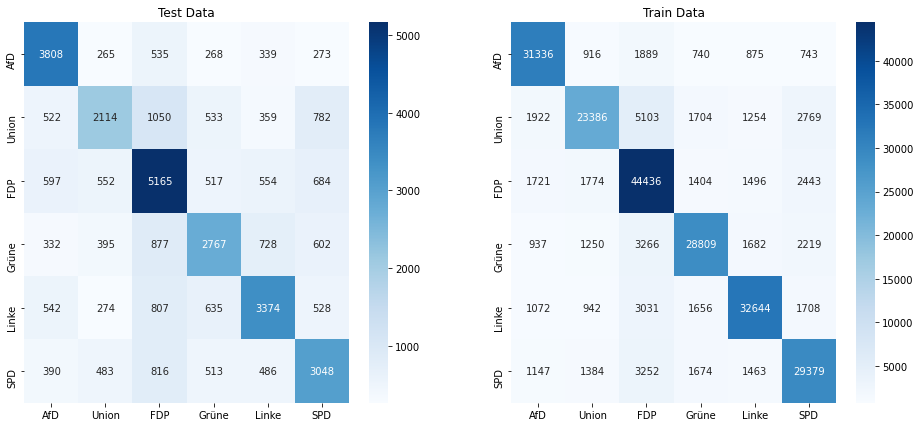

Party: 	 Test 	 Train
Afd:	 5488 	 36499
Union:	 5360 	 36138
FDP:	 8069 	 53274
Grüne:	 5701 	 38163
Linke:	 6160 	 41053
SPD:	 5736 	 38299

Acc:	 55.53% 78.05%


In [14]:
#visualizing test 2
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = m5.model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');


# Block to evaluate test data
yhat_train = m5.model.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

In [15]:
# Deep learning Model 5 (see RNN_all_data notebook)
class RnnModel5():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        x = Bidirectional(LSTM(512, return_sequences=True))(x)
        x = Bidirectional(LSTM(256))(x)
        x = Dense(256, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(256, activation="relu")(x)
        x = Dense(64, activation="relu")(x)
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model

In [16]:
# test 3 with no party matrix
m6 = RnnModel5(em_matrix, 300, 50)
h6 = m6.model.fit(X_train, y_train, epochs = 5, batch_size = 512, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/5
476/476 [==============================] - 2041s 4s/step - loss: 0.3947 - accuracy: 0.3648 - val_loss: 0.3488 - val_accuracy: 0.4667
Epoch 2/5
476/476 [==============================] - 2092s 4s/step - loss: 0.3122 - accuracy: 0.5413 - val_loss: 0.3146 - val_accuracy: 0.5356
Epoch 3/5
476/476 [==============================] - 2173s 5s/step - loss: 0.2609 - accuracy: 0.6312 - val_loss: 0.3088 - val_accuracy: 0.5551
Epoch 4/5
476/476 [==============================] - 2193s 5s/step - loss: 0.2201 - accuracy: 0.6961 - val_loss: 0.3235 - val_accuracy: 0.5528
Epoch 5/5
476/476 [==============================] - 1969s 4s/step - loss: 0.1866 - accuracy: 0.7436 - val_loss: 0.3664 - val_accuracy: 0.5593


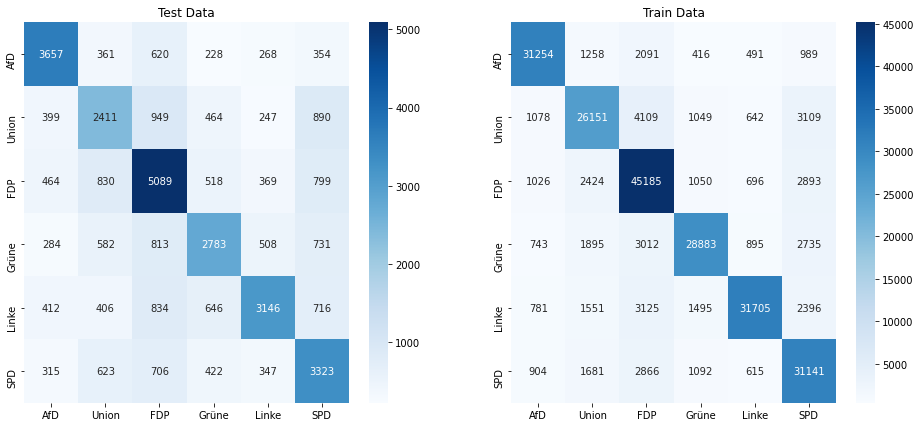

Party: 	 Test 	 Train
Afd:	 5488 	 36499
Union:	 5360 	 36138
FDP:	 8069 	 53274
Grüne:	 5701 	 38163
Linke:	 6160 	 41053
SPD:	 5736 	 38299

Acc:	 55.89% 79.83%


In [17]:
#visualizing test 3
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = m6.model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');

# Block to evaluate test data
yhat_train = m6.model.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])

sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

In [20]:
# export test 1
S = "remove_party_{mod}_ep{epo}_acc{acc}_valacc{valacc}".format(
        mod='Rnn2',
        epo=5,
        acc="{:2.2f}".format(h2.history["accuracy"][-1] * 100),
        valacc="{:2.2f}".format(h2.history["val_accuracy"][-1]*100),
    )
m2.model.save_weights('models/'+S+'/model_weights')

In [19]:
# export test 2

S = "remove_party_{mod}_ep{epo}_acc{acc}_valacc{valacc}".format(
        mod='Rnn4',
        epo=5,
        acc="{:2.2f}".format(h5.history["accuracy"][-1] * 100),
        valacc="{:2.2f}".format(h5.history["val_accuracy"][-1]*100),
    )
m5.model.save_weights('models/'+S+'/model_weights')

In [18]:
# export test 3
S = "remove_party_{mod}_ep{epo}_acc{acc}_valacc{valacc}".format(
        mod='Rnn5',
        epo=5,
        acc="{:2.2f}".format(h6.history["accuracy"][-1] * 100),
        valacc="{:2.2f}".format(h6.history["val_accuracy"][-1]*100),
    )
m6.model.save_weights('models/'+S+'/model_weights')